# Drive operations

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)


drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

In [2]:
%cd 'drive/My Drive/Workspaces/aerial_image_object_detection'

/content/drive/My Drive/Workspaces/aerial_image_object_detection


In [1]:
%pwd

'/content'

# Data import

## Kaggle operations

In [ ]:
! pip install -q kaggle

In [ ]:
! pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.9)


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bikramdutta","key":"bf444a1368eac7ee1cd4e745d095904a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json



In [ ]:
! kaggle competitions download -c 'aerial-cactus-identification'

 26% 5.00M/19.2M [00:00<00:00, 50.6MB/s]
100% 19.2M/19.2M [00:00<00:00, 94.4MB/s]
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 44.0MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.1MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 22.7MB/s]


# Data import and inspection

In [5]:
%ls -ltr

total 36
-rw------- 1 root root    66 Nov 23 15:44 README.md
-rw------- 1 root root    67 Nov 23 16:24 kaggle.json
drwx------ 2 root root  4096 Nov 23 16:52 data/
-rw------- 1 root root 31426 Nov 23 17:58 aerial_cactus_identification.ipynb


In [6]:
import pandas as pd

train_df = pd.read_csv('data/aci/train.csv')

In [7]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


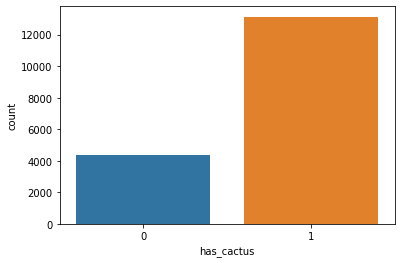

In [8]:
train_df.has_cactus.value_counts(dropna=False)
import seaborn as sns
sns.countplot(train_df.has_cactus)

## Arranging the training data folder wise

In [ ]:
categories = ['no_cactus', 'cactus']
import os
PATH = os.path.join(os.getcwd(),'data','aci', 'train')
os.mkdir(PATH) if not os.path.exists(PATH) else print(PATH, 'exists')
for cat in categories:
  cat_path = os.path.join(PATH, cat)
  os.mkdir(cat_path)

/content/drive/My Drive/Workspaces/aerial_image_object_detection/data/aci/train exists


In [ ]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
!unzip train.zip

In [ ]:
train_df.shape

for row in range(train_df.shape[0]):
  category = 'cactus' if train_df.iloc[row,1] == 1 else 'no_cactus'
  
  os.rename(train_df.iloc[row,0],category + '/' + train_df.iloc[row,0])

In [ ]:
%cd train

/content/drive/My Drive/Workspaces/aerial_image_object_detection/data/aci/train


In [ ]:
%cd /content/drive/My Drive/Workspaces/aerial_image_object_detection/

/content/drive/My Drive/Workspaces/aerial_image_object_detection


## Image Data Generator

In [13]:
DATA_DIR = 'data/aci/train'
IMAGE_SIZE = 150

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# create the generator object
train_data_gen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                    validation_split= 0.2)


In [20]:
train_data = train_data_gen.flow_from_directory(DATA_DIR,
                                                batch_size=10,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                subset='training')

test_data = train_data_gen.flow_from_directory(DATA_DIR,
                                                batch_size=10,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                subset='validation')

Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.


In [ ]:
# # saving the generated datasets for quick retrieval
# import pickle
# import os

# os.mkdir('data/aci/train/saved_data/')

# pickle_out = open('data/aci/train/saved_data/train_gen.pkl','wb')
# pickle.dump(train_data,pickle_out)
# pickle_out.close()

# pickle_out = open('data/aci/train/saved_data/test_gen.pkl','wb')
# pickle.dump(test_data,pickle_out)
# pickle_out.close()


# Creating the Model

In [26]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, ZeroPadding2D, BatchNormalization

In [27]:
import time

# set variables

layer_sizes = [32,64,128]
conv_layers = [1,2]
dense_layers = [0,1,2]

for dense_layer in dense_layers:
  for layer_size in layer_sizes:
    for conv_layer in conv_layers:

      NAME = '{}-conv-{}-nodes-{}-dense-{}'.format(conv_layer, layer_size, dense_layer, int(time.time()))
      print(NAME)
      tensorboard = TensorBoard(log_dir='aci_logs/{}'.format(NAME))
      
      model = Sequential()

      # Add the convolutional layers
      model.add(Conv2D(layer_size, (3,3), input_shape= (IMAGE_SIZE,IMAGE_SIZE,3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      for cL in range(conv_layer - 1):
        model.add(Conv2D(layer_size, (3,3), input_shape= (IMAGE_SIZE,IMAGE_SIZE,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
      
      # Flatten the Convoluted output
      model.add(Flatten())

      # Add dropout layer to reduce overfitting
      model.add(Dropout(0.5))

      # Add dense layers
      for dL in range(dense_layer):
        model.add(Dense(layer_size,activation='relu'))

      # Add output layer
      model.add(Dense(2,activation='softmax'))

      # Compile the model for the combination

      model.compile(loss= 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])
      
      model.fit(train_data, batch_size = 10, epochs = 10, validation_data = test_data, callbacks=[tensorboard])      

1-conv-32-nodes-0-dense-1606407790
Epoch 1/10
   1/1401 [..............................] - ETA: 0s - loss: 0.7106 - accuracy: 0.5000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
   6/1401 [..............................] - ETA: 1:42:24 - loss: 2.9302 - accuracy: 0.7333

KeyboardInterrupt: ignored